In [59]:
import numpy as np
from scipy.sparse import csc_matrix
import time
import matplotlib.pyplot as plt

# Hyper-parameters 
beta = 0.8

# Load IDs of page link origins and targets and all unqiue IDS
ID_From = np.load('ID_From.npy')
ID_To = np.load('ID_To.npy')

# Find unique page IDs
# These pages will be both the rows and columns of our matrix M
ID_Unique = np.unique(np.concatenate((ID_From, ID_To), axis=0))

# Count nonzero outgoing links
# This will serve as the denominator for the columns of our matrix M
# ie, assuming even probability 1 / (the total outgoing count) is the 
# proability of going to the page of a row from the page of a column
ID_Outgoing_Nonzero, ID_Outgoing_Count = np.unique(ID_From, return_counts=True)

# Create our matrix
M = csc_matrix((np.ones(len(ID_From)), (ID_To, ID_From)), shape=(len(ID_Unique), len(ID_Unique)))

# Normalize dividing columns by total count 
# Will use 1 if dead end - will still be 0 - no entry in sparse - but avoids nans
Norm = np.ones(len(ID_Unique))
Norm[ID_Outgoing_Nonzero] = ID_Outgoing_Count
val = np.repeat(Norm, M.getnnz(axis=0)) # This keeps the sparse matrix a sparse matrix
M.data /= val



In [60]:
# Create v with even inital distribution
start_time = time.time() # Record the starting time 
# Initialize the v_old 
v_old = np.ones(len(ID_Unique))/len(ID_Unique)
v_teleport = (np.ones(len(ID_Unique)) - beta)/len(ID_Unique)
# Determine the number of iterations we wanna run 
iterations = 25
# Prepare an array to store MSE
MSE = np.zeros(iterations)
# for each iteration
for iteration in range(iterations):
    # Mv will be updated
    Mv = np.zeros(len(ID_Unique))
    # for each page
    for i in range(M.shape[1]):
        # get indice of where this page can go
        indice = csc_matrix.nonzero(M[:,i])
        # Count how many pages we can go from this current page
        d_i = csc_matrix.getnnz(M[:,i])
        # for each page where we can go
        for j in range(d_i):
            # update Mv += ****
            Mv[indice[0][j]] += beta * v_old[i]/d_i
            # We don't want to update v_new as the same algorithm as it from slides becasue we need to know M*v \
            # in order to calculte the MSE. Following v_new is the algorithm from slides to show our understanding.
            #v_new[indice[0][j]] += beta * v_old[i]/d_i
    # Calculate the MSE after one iteration
    MSE[iteration] = sum((v_old - Mv)**2)
    # update v_old with Mv + v_new
    v_new = Mv + v_teleport
    v_old = v_new
# Print estimated time cost by each iteration
print('A single iteration takes ',(time.time() - start_time)/iterations,' second')

A single iteration takes  76.41052629470825  second


In [61]:
csc_matrix.getnnz(M[:,0])

193

In [62]:
csc_matrix.nonzero(M[:,0])[0]

array([   234,    240,   1365,   1707,   1910,   2446,   3072,   3182,
         3282,   3391,   3549,   4632,   4638,   4640,   4833,   4918,
         4956,   5688,   5745,   5747,   6074,   6086,   6287,   6949,
         7524,   7529,   8228,   8259,   8541,   9382,   9488,   9744,
        11205,  11470,  12197,  12210,  12244,  12245,  12616,  12935,
        13459,  13839,  13884,  13981,  14355,  14783,  15053,  16070,
        16362,  16450,  16495,  17081,  17256,  17257,  17595,  17631,
        17653,  17727,  17742,  17794,  17905,  18033,  18369,  18373,
        18381,  18382,  18402,  18413,  18421,  18425,  18459,  18461,
        18477,  18478,  18487,  18493,  18501,  18502,  18516,  18568,
        18591,  18592,  18643,  19179,  20289,  20379,  20426,  23394,
        23857,  24998,  25535,  25907,  25908,  26903,  27798,  28316,
        28321,  30898,  31416,  32427,  32969,  34899,  36029,  36895,
        37647,  38796,  39006,  41443,  43189,  43770,  46252,  47092,
      

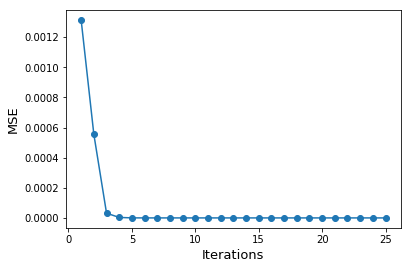

The final MSE = 1.6124085035089927e-07


In [63]:
# Plot MSE values w.r.t iterations.
plt.figure()
plt.plot(np.linspace(1,iterations,iterations),MSE,'-o')
plt.xlabel('Iterations',fontsize = 13)
plt.ylabel('MSE',fontsize = 13)
plt.show()
print('The final MSE =',MSE[-1])

In [66]:
np.save('MSE.npy',MSE)